In [33]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


In [40]:
base_dir = "../logs/SPEC-CPU/v3/"
# Define trace names and configuration labels
trace_names = [ '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B','602.gcc_s-2226B', '623.xalancbmk_s-10B']
configs = ['ipcp', 'ipcp_isb-V3-train_on_miss-pf_on_all', 'isb-l1']


# Initialize a dictionary to store IPC values for each trace and configuration
acc_values = {trace: {} for trace in trace_names}
cov_values = {trace: {} for trace in trace_names}


In [41]:
def extract_accuracy(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'L1D USEFUL LOAD PREFETCHES' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                acc_value = float(re.search(r"ACCURACY:\s([\d\.]+)", line).group(1))
                return acc_value
    return None

def extract_coverage(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'Coverage' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                cov_value = float(re.search(r"Coverage:\s([\d\.]+)", line).group(1))
                return cov_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        acc_values[trace][config] = extract_accuracy(log_file)
        cov_values[trace][config] = extract_coverage(log_file)


In [42]:
# Calculate geometric mean for each configuration
geomeans = {}
for config in configs:
    config_val = [acc_values[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_val)

acc_values['Geomean'] = geomeans

geomeans = {}
for config in configs:
    config_val = [cov_values[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_val)

cov_values['Geomean'] = geomeans
trace_names += ['Geomean']

In [43]:
acc_values

{'450.soplex-247B': {'ipcp': 42.5776,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 43.9304,
  'isb-l1': 51.1815},
 '462.libquantum-714B': {'ipcp': 85.8696,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 83.7635,
  'isb-l1': 87.9975},
 '471.omnetpp-188B': {'ipcp': 16.7072,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 32.4242,
  'isb-l1': 45.4776},
 '482.sphinx3-234B': {'ipcp': 63.0255,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 67.5332,
  'isb-l1': 73.7325},
 '602.gcc_s-2226B': {'ipcp': 89.9801,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 87.1465,
  'isb-l1': 94.2104},
 '623.xalancbmk_s-10B': {'ipcp': 19.9888,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 56.7995,
  'isb-l1': 94.6495},
 'Geomean': {'ipcp': np.float64(43.65784525191006),
  'ipcp_isb-V3-train_on_miss-pf_on_all': np.float64(58.45210723212515),
  'isb-l1': np.float64(71.59392439735902)}}

In [44]:
cov_values

{'450.soplex-247B': {'ipcp': 32.7582,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 50.6299,
  'isb-l1': 35.457},
 '462.libquantum-714B': {'ipcp': 81.7991,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 82.4751,
  'isb-l1': 76.4002},
 '471.omnetpp-188B': {'ipcp': 9.55546,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 53.6305,
  'isb-l1': 49.6061},
 '482.sphinx3-234B': {'ipcp': 77.0089,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 78.4828,
  'isb-l1': 65.8929},
 '602.gcc_s-2226B': {'ipcp': 94.8255,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 93.6672,
  'isb-l1': 86.5709},
 '623.xalancbmk_s-10B': {'ipcp': 14.0627,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 68.7813,
  'isb-l1': 56.1161},
 'Geomean': {'ipcp': np.float64(37.15145449750923),
  'ipcp_isb-V3-train_on_miss-pf_on_all': np.float64(69.5551079292705),
  'isb-l1': np.float64(59.19317023678794)}}

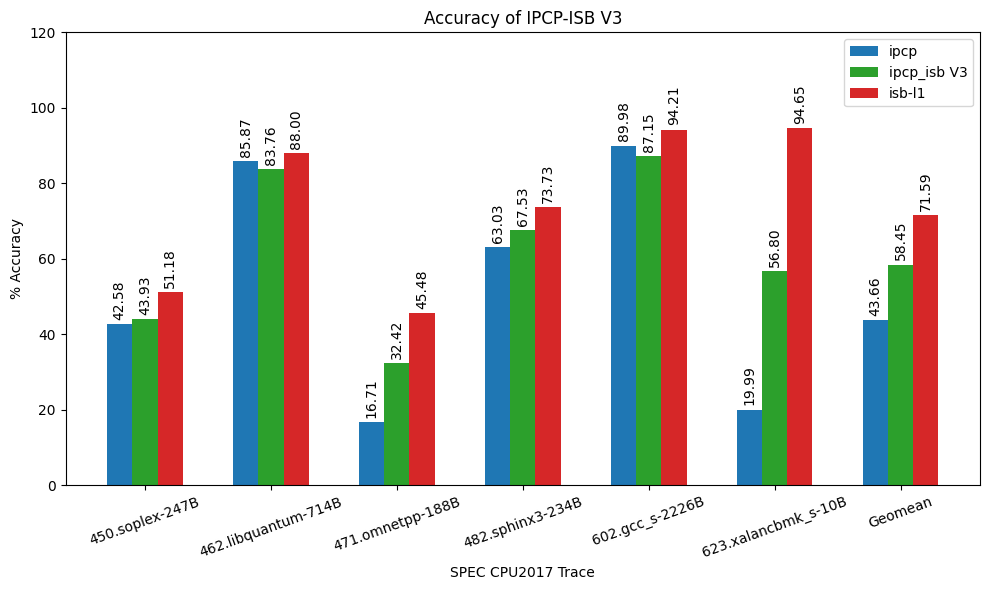

In [53]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.2  # Width of the bars
colors = ["tab:blue", "tab:green", "tab:red"]
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each configuration
for i, config in enumerate(configs):  # Skip baseline
    _values = [acc_values[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, _values, width, label=config, color = colors[i])
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylabel('% Accuracy')
ax.set_ylim(0.0, 120.0)
ax.set_title('Accuracy of IPCP-ISB V3')
ax.set_xticks(x + 2*width / 2)
ax.set_xticklabels(trace_names, rotation=20)
ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()

# Update the labels
plt.legend(handles, ['ipcp', 'ipcp_isb V3', 'isb-l1'])

# Show the plot
plt.tight_layout()
plt.show()


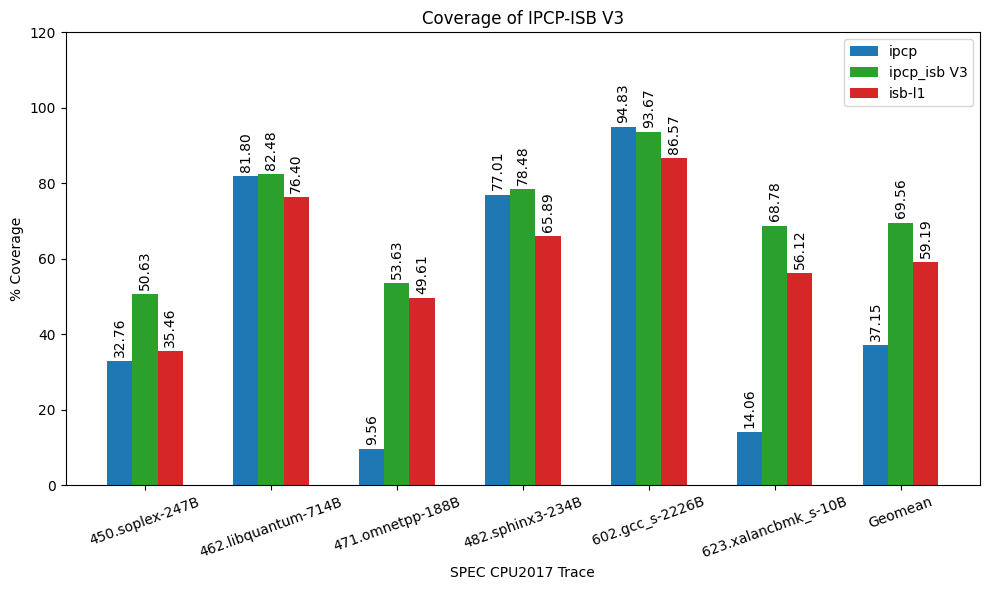

In [54]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.2  # Width of the bars
colors = ["tab:blue", "tab:green", "tab:red"]
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each configuration
for i, config in enumerate(configs):  # Skip baseline
    _values = [cov_values[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, _values, width, label=config, color=colors[i])
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylabel('% Coverage')
ax.set_ylim(0.0, 120.0)
ax.set_title('Coverage of IPCP-ISB V3')
ax.set_xticks(x + 2*width / 2)
ax.set_xticklabels(trace_names, rotation=20)
ax.legend()
# Retrieve existing handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Update the labels
plt.legend(handles, ['ipcp', 'ipcp_isb V3', 'isb-l1'])

# Show the plot
plt.tight_layout()
plt.show()
